In [1]:
import calendar

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import train
import quantiles
import adjust

In [2]:
hist_file = '/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/day/tasmax/gn/latest/tasmax_day_ACCESS-ESM1-5_historical_r1i1p1f1_gn_20000101-20141231.nc'

In [3]:
ds_hist = xr.open_dataset(hist_file)
ds_hist = ds_hist.sel({'lat': slice(-36, -32), 'lon': slice(140, 144)})
with xr.set_options(keep_attrs=True):
    ds_hist['tasmax'] = ds_hist['tasmax'] - 273.15
ds_hist['tasmax'].attrs['units'] = 'C'

In [4]:
monthly_quantiles = ds_hist['tasmax'].groupby('time.month').quantile([0.25, 0.5, 0.75], dim='time', keep_attrs=True)

In [5]:
da_hist_by_month = ds_hist['tasmax'].groupby('time.month')
below_q50 = da_hist_by_month < monthly_quantiles.sel(quantile=0.5)

In [6]:
# ds_ref: add 1.0 to values below the 50th percentile and 6.0 to values above 50th percentile
ds_ref = ds_hist.copy()
ds_ref['tasmax'] = da_hist_by_month.where(below_q50)
ds_ref['tasmax'] = ds_ref['tasmax'].fillna(ds_hist['tasmax'] + (ds_ref['month'] * 10))
del ds_ref['month']
with xr.set_options(keep_attrs=True):
    ds_ref['tasmax'] = ds_ref['tasmax'] + 1

In [7]:
ds_target = ds_hist.copy()

In [8]:
ds_adjust = train.train(ds_hist, ds_ref, 'tasmax', 'tasmax', 'additive')

In [9]:
point_selection = {'lat': 0, 'lon': 0}

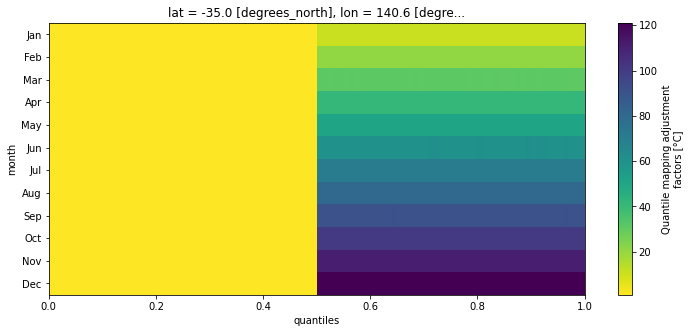

In [10]:
fig = plt.figure(figsize=[12, 5])
ax1 = fig.add_subplot(111)

af = ds_adjust['af'].isel(point_selection)
af.transpose('month', 'quantiles').plot(ax=ax1, cmap='viridis_r', extend='neither')
yticks = np.arange(1, 13)
ytick_labels = [calendar.month_abbr[i] for i in yticks]
ax1.set_yticks(yticks, ytick_labels)
ax1.invert_yaxis()

plt.show()

In [11]:
ds_target_q = quantiles.quantiles(ds_target, 'tasmax', 100)

In [12]:
ds_qq = adjust.adjust(
    ds_target,
    'tasmax',
    ds_adjust,
    da_q=ds_target_q['tasmax'],
    reverse_ssr=False,
    ref_time=False,
    interp='nearest'
)

In [13]:
qq_q = quantiles.quantiles(ds_qq, 'tasmax', 100)

In [14]:
def compare_quantiles(month):
    """Quantile comparison"""

    obs_data = ds_adjust['hist_q'].isel({'lat': 0, 'lon': 0, 'month': month}).values
    qq_data = qq_q['tasmax'].isel({'lat': 0, 'lon': 0, 'month': month}).values
    hist_data = ds_adjust['hist_q'].isel({'lat': 0, 'lon': 0, 'month': month}).values
    future_data = ds_adjust['ref_q'].isel({'lat': 0, 'lon': 0, 'month': month}).values
    quantiles = ds_adjust['quantiles'].data * 100

    fig = plt.figure(figsize=[15, 5])
    ax1 = fig.add_subplot(122)
    ax2 = fig.add_subplot(121)

    ax1.bar(quantiles, obs_data, alpha=0.5, label='observations')
    ax1.bar(quantiles, qq_data, alpha=0.5, label='qq-scaled data')
    ax2.bar(quantiles, hist_data, alpha=0.5, label='historical')
    ax2.bar(quantiles, future_data, alpha=0.5, label='ssp370')

    ax1.set_xlim(0, 100)
    #ax1.set_ylim(0, 120)
    ax1.grid()
    ax1.legend()
    ax1.set_xlabel('quantile')

    ax2.set_xlim(0, 100)
    #ax2.set_ylim(0, 120)
    ax2.grid()
    ax2.legend()
    ax2.set_ylabel('tasmax (C)')
    ax2.set_xlabel('quantile')

    title = calendar.month_name[month + 1]
    plt.suptitle(title)

    plt.show()
    
    print('QQ-data')
    print(qq_data - obs_data)
    
    print('GCM data')
    print(future_data - hist_data)

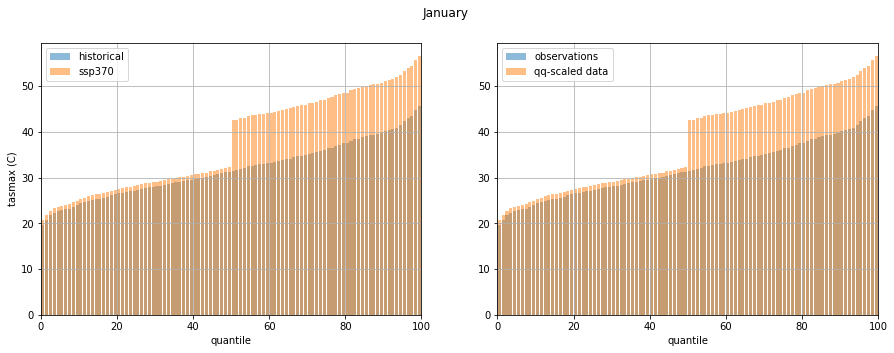

QQ-data
[ 0.99999924  1.          0.99999847  1.00000046  1.00000092  0.99999906
  0.99999878  1.00000076  0.99999863  1.00000076  1.00000031  0.99999878
  1.          1.00000015  1.00000046  0.99999832  0.99999924  1.00000153
  1.00000046  1.00000061  1.00000046  0.99999817  0.99999924  1.00000122
  0.99999878  1.          0.99999985  0.99999924  0.99999908  1.00000031
  0.99999939  0.99999924  0.99999924  0.99999878  1.00000168  1.00000092
  0.99999786  1.          1.00000137  0.99999985  1.00000092  1.00000031
  1.          0.99999863  1.00000031  1.00000168  0.99999802  1.00000229
  0.99999924  1.00000046 11.00000061 10.99999969 11.00000305 10.99999847
 11.00000183 11.00000031 10.99999939 11.         10.99999908 10.99999603
 10.99999695 11.00000031 11.         11.00000275 10.99999664 10.99999969
 10.99999878 10.99999695 10.99999847 11.00000366 11.00000305 11.00000061
 10.99999847 10.99999638 10.99999847 11.00000336 10.99999908 11.
 11.00000183 10.99999542 10.99999817 11.00000183 11

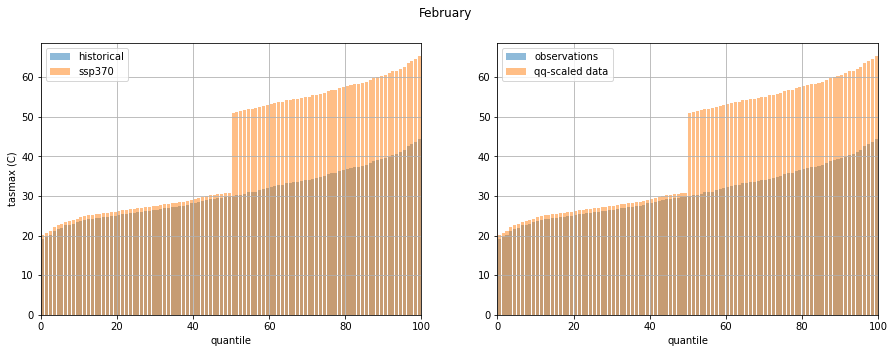

QQ-data
[ 1.00000061  1.00000183  1.          1.00000092  1.00000137  0.99999847
  1.00000046  0.99999847  0.99999832  1.00000137  0.99999924  1.00000092
  1.          1.00000183  0.99999924  1.00000031  0.99999969  1.00000001
  1.00000107  0.99999969  0.99999847  0.99999832  1.00000076  0.99999893
  1.00000153  0.99999908  1.00000214  0.99999924  1.00000168  0.99999908
  0.99999985  0.99999863  0.99999847  1.00000015  1.00000137  1.00000153
  1.          1.          0.99999954  1.00000015  1.00000122  1.00000092
  0.99999739  0.99999817  1.          1.00000015  0.99999878  0.99999924
  0.99999817  0.99999924 20.99999985 20.99999863 21.00000229 20.99999664
 20.99999817 21.00000122 20.99999878 21.00000076 21.00000046 20.99999756
 21.00000122 21.00000305 21.         21.00000305 21.00000427 20.99999908
 21.00000153 21.         20.99999756 20.99999756 21.00000305 20.99999725
 20.99999847 20.99999878 21.00000275 21.00000153 21.00000183 21.00000458
 20.99999786 20.99999573 20.99999817 20.999

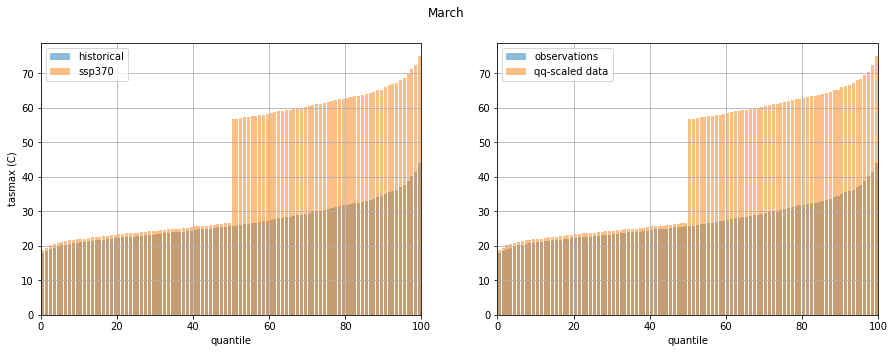

QQ-data
[ 0.99999924  0.99999924  1.00000153  1.00000122  0.99999908  0.99999878
  1.00000076  1.00000153  1.00000168  0.99999847  1.00000092  0.99999985
  1.          1.00000122  1.00000122  1.00000061  0.99999832  0.99999847
  0.99999817  1.00000061  0.99999893  0.99999908  1.00000076  0.99999832
  1.00000092  1.00000076  1.00000183  0.99999771  0.99999985  0.99999893
  0.99999863  1.00000168  1.00000153  1.00000107  1.00000153  1.00000046
  1.00000092  1.          0.99999878  1.00000122  0.99999847  1.00000107
  1.          1.00000168  0.99999985  1.00000076  0.99999817  1.00000076
  0.99999908  1.         31.00000046 31.00000061 30.99999847 31.00000137
 31.00000015 30.99999847 31.00000092 30.99999847 30.99999908 31.
 31.00000031 31.00000046 31.         31.00000183 31.00000168 31.00000305
 30.99999954 30.99999771 30.99999969 30.99999847 30.99999924 31.00000046
 31.         30.99999924 30.99999985 31.00000183 30.99999985 31.
 30.99999725 31.         31.00000015 30.99999878 30.9999984

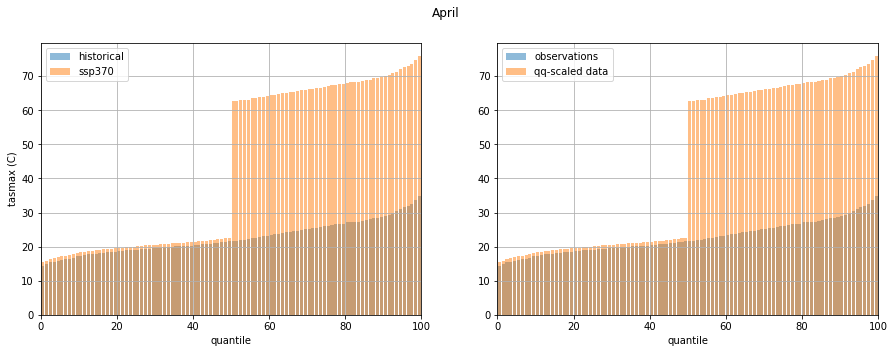

QQ-data
[ 1.00000061  0.99999916  1.          1.00000046  1.00000038  1.00000061
  1.00000034  0.99999924  1.00000107  1.00000153  1.00000153  1.00000137
  1.          0.99999832  0.99999893  1.00000122  0.99999786  1.00000153
  0.99999847  1.00000015  0.99999985  0.99999863  0.99999924  1.00000092
  1.00000061  1.00000061  1.00000214  0.99999847  1.          1.00000173
  0.99999878  1.00000015  1.00000076  0.99999832  0.99999878  1.00000015
  0.99999939  1.          0.99999908  1.00000137  0.99999985  0.99999939
  0.99999924  0.99999954  1.00000198  1.00000076  0.99999878  1.
  1.00000046  0.99999908 41.00000168 41.00000214 41.00000229 41.00000031
 41.00000092 40.99999969 40.99999954 41.00000076 41.00000015 41.00000015
 41.00000061 40.99999817 41.         41.00000076 41.00000222 41.00000031
 40.99999817 41.00000076 41.00000088 41.00000198 41.00000259 40.99999878
 40.99999771 41.00000092 40.99999817 41.00000137 41.00000229 41.00000076
 41.00000092 41.00000076 40.99999908 41.00000015 41

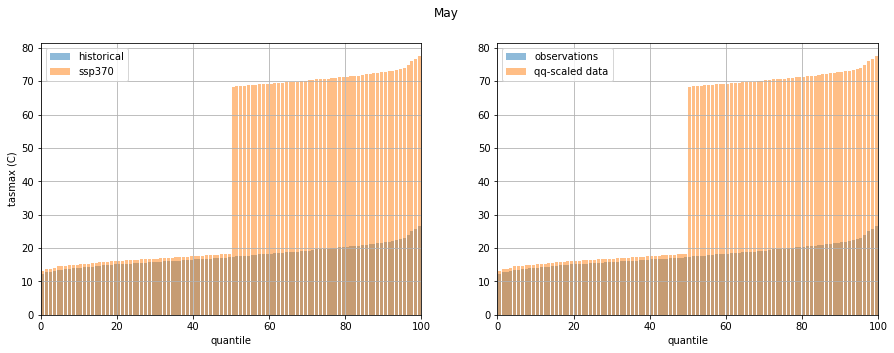

QQ-data
[ 1.00000092  1.00000046  1.          1.00000061  1.00000023  1.00000061
  0.99999969  1.00000038  1.00000038  1.00000069  1.00000062  1.00000061
  1.          1.00000053  1.00000038  0.99999908  1.00000061  1.00000076
  0.99999931  0.99999947  1.00000092  1.00000031  1.          1.00000069
  0.99999924  1.00000046  1.00000107  0.99999924  0.99999916  1.00000099
  1.00000092  0.99999916  1.00000153  0.99999985  1.00000122  0.99999954
  1.00000122  1.          1.          1.00000107  0.99999985  0.99999863
  1.          0.99999893  0.99999924  1.00000137  0.99999939  0.99999847
  1.00000033  1.00000137 50.99999832 51.00000183 50.99999924 50.99999985
 51.00000015 51.         51.00000198 51.00000076 51.00000137 50.99999954
 51.00000107 51.00000061 51.         50.99999937 51.00000046 51.00000222
 50.99999985 51.00000076 50.99999832 51.00000183 51.00000015 50.99999985
 51.00000153 50.99999939 51.00000031 51.00000076 50.99999908 51.00000076
 51.00000137 50.99999969 51.00000076 51.000

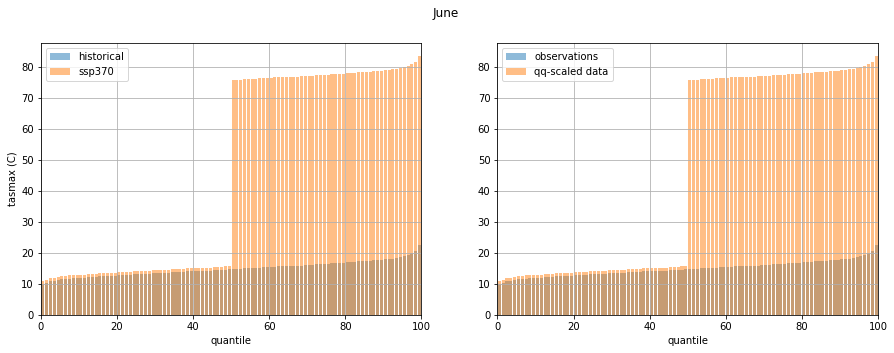

QQ-data
[ 0.99999924  0.99999916  1.          0.99999992  1.00000076  1.00000008
  1.00000092  0.99999924  0.99999908  0.99999908  0.99999947  0.99999901
  1.          0.99999992  1.00000099  1.00000061  0.99999962  0.99999924
  0.99999954  0.99999954  1.00000038  0.99999962  0.99999924  1.00000046
  0.99999992  1.00000069  1.00000038  1.00000076  0.99999949  0.99999977
  1.00000031  1.00000015  0.99999964  1.00000008  0.99999908  1.00000069
  0.99999901  1.          0.99999954  1.00000069  0.99999908  1.00000084
  0.99999962  0.99999962  0.99999954  1.00000076  1.00000046  0.99999924
  1.00000031  1.00000076 61.00000061 61.00000053 61.00000076 61.00000069
 61.00000061 61.00000015 61.         61.00000038 61.         60.99999878
 60.99999916 60.99999947 61.         61.00000053 60.99999962 61.00000031
 61.00000008 60.99999962 60.99999916 60.99999954 60.99999893 61.00000214
 61.00000153 60.99999786 60.99999878 61.00000091 61.00000046 61.
 60.99999832 61.00000031 61.00000168 60.99999817 60

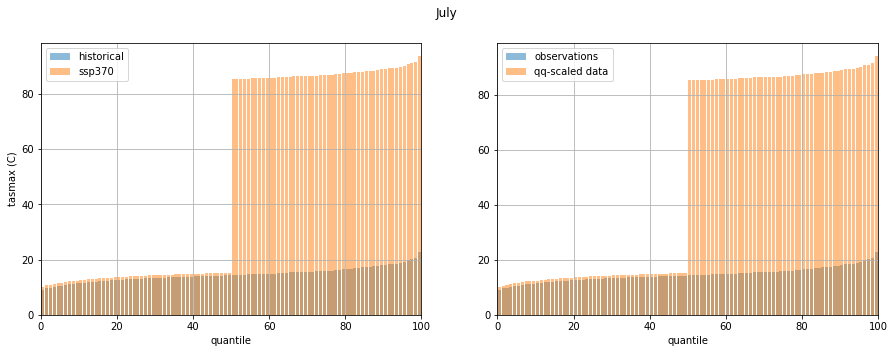

QQ-data
[ 0.99999985  0.99999954  1.00000038  0.99999954  0.99999947  1.00000031
  0.99999931  0.99999924  1.00000046  1.00000069  1.00000008  1.00000053
  1.          0.99999924  0.99999992  1.00000046  0.99999924  1.00000038
  0.99999977  0.99999969  0.99999954  0.99999954  1.          1.00000023
  1.00000008  0.99999954  1.00000061  0.99999924  1.00000038  0.99999985
  1.00000084  1.00000053  1.00000076  0.99999954  0.99999992  1.00000015
  1.00000031  1.          0.99999916  0.99999924  0.99999992  1.00000076
  0.99999924  0.99999985  0.99999924  1.00000046  1.00000031  1.
  1.00000076  0.99999969 70.99999947 71.00000023 71.00000076 71.
 70.99999977 71.00000061 70.99999939 70.99999925 70.99999954 70.99999924
 70.99999931 71.00000084 71.         71.00000046 71.00000069 71.00000092
 70.99999901 71.00000038 71.00000046 70.99999977 70.99999969 70.99999954
 71.00000038 70.99999908 71.00000084 71.00000023 71.00000031 71.
 70.99999924 70.99999908 70.99999908 70.99999863 71.         71.000

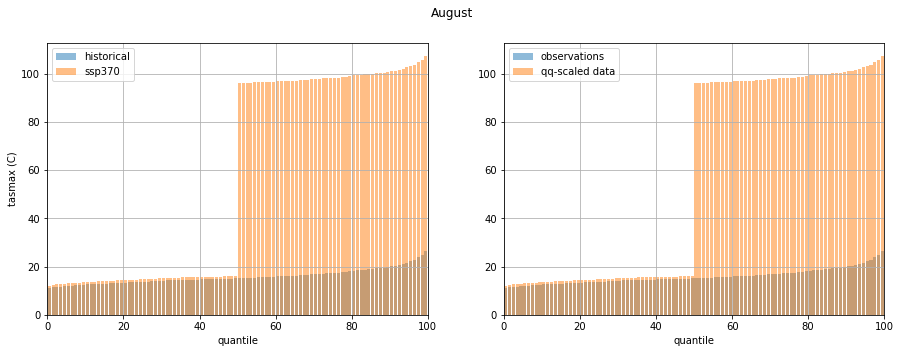

QQ-data
[ 0.99999939  1.00000076  1.00000038  1.          1.00000008  1.00000053
  1.00000008  0.99999962  0.99999924  1.00000092  0.99999947  1.00000076
  1.          1.00000023  0.99999969  1.00000069  1.00000015  1.
  0.99999939  1.00000023  1.00000061  0.99999908  1.          1.00000067
  0.99999962  1.00000069  1.00000031  0.99999962  0.99999954  1.00000084
  1.00000015  1.00000008  1.00000076  1.00000061  0.99999962  1.00000053
  1.00000069  1.          0.99999924  1.00000046  0.99999939  1.00000069
  1.          1.00000031  0.99999977  1.00000038  1.00000046  1.
  0.99999993  1.00000008 80.99999962 80.99999992 81.         80.99999809
 80.99999908 81.00000031 81.00000008 81.         80.99999962 80.99999878
 80.99999878 81.00000031 81.         81.00000015 80.99999954 80.99999908
 80.99999832 80.99999924 81.00000137 81.00000061 81.00000061 80.99999878
 81.00000076 80.99999893 81.00000061 80.99999969 81.00000168 81.00000076
 81.00000122 80.99999817 80.99999969 81.00000198 81.0000007

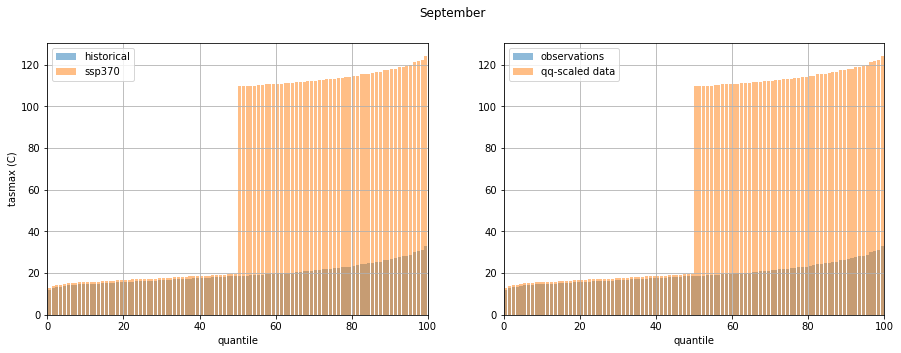

QQ-data
[ 1.00000061  1.00000008  1.00000038  1.00000038  0.99999931  1.00000038
  0.99999939  0.99999924  1.00000092  1.00000084  0.99999924  1.00000069
  1.          0.99999962  0.99999931  0.99999931  0.99999985  1.
  1.00000023  0.99999977  1.00000008  0.99999916  1.          0.99999916
  0.99999939  0.99999908  1.00000168  0.99999847  1.00000046  1.00000015
  0.99999954  1.00000122  1.          1.          1.00000092  0.99999969
  1.00000092  1.          0.99999969  1.00000168  0.99999908  1.00000107
  1.          1.          0.99999878  0.99999863  0.99999863  0.99999847
  1.00000153  1.00000031 91.         91.00000076 91.00000153 91.00000046
 90.99999878 90.99999878 91.00000092 91.00000153 91.00000137 91.00000015
 90.99999771 90.99999924 91.         91.00000015 91.0000032  91.00000183
 90.99999985 91.         90.99999832 91.00000214 91.00000061 91.00000092
 90.99999847 90.99999939 90.99999985 90.99999924 90.99999969 90.99999924
 91.00000153 90.99999832 91.         91.00000122 91

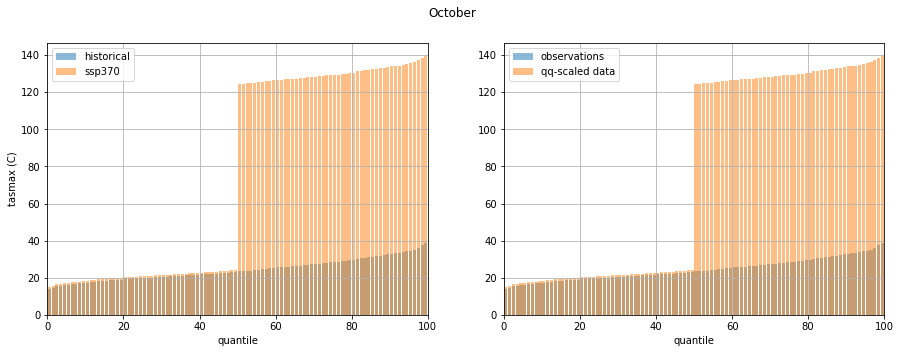

QQ-data
[  1.00000053   0.99999947   1.00000038   0.99999931   1.00000015
   0.99999863   1.00000198   1.           0.99999908   1.
   0.99999939   1.00000137   1.           1.00000092   0.99999847
   1.00000122   1.00000183   1.00000153   0.99999886   1.00000092
   1.00000168   0.99999924   1.           0.99999863   1.
   0.99999924   0.99999954   1.00000153   0.99999908   0.99999969
   1.00000031   1.00000015   1.00000153   0.99999985   1.00000183
   0.99999939   0.99999832   1.           1.00000092   0.99999802
   1.00000046   0.99999924   1.00000153   1.00000107   0.99999924
   0.99999802   1.00000076   1.00000153   1.           1.00000107
 100.99999878 101.00000137 101.         101.00000015 101.00000087
 101.00000122 101.00000137 101.         100.99999863 100.99999817
 101.00000137 101.00000137 101.         100.99999847 101.00000122
 101.00000107 101.00000122 101.         101.00000061 101.00000092
 101.00000546 101.00000015 100.99999695 100.99999924 100.99999954
 101.00000107 101.

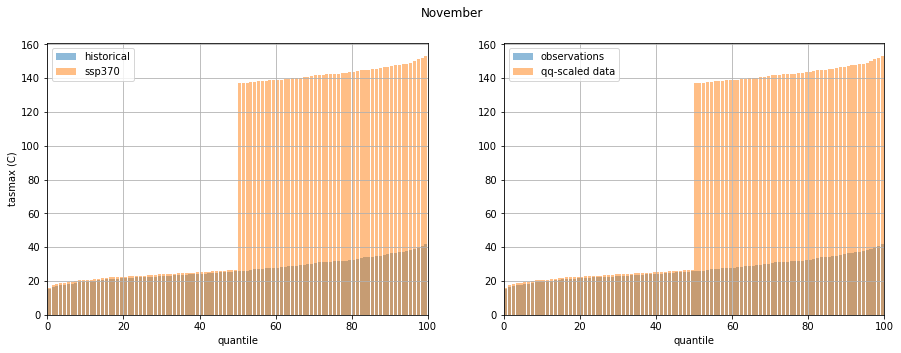

QQ-data
[  1.00000015   0.99999924   1.00000153   0.99999878   1.00000168
   0.99999832   0.99999893   0.99999847   1.00000092   1.00000153
   1.00000153   1.00000046   1.           1.00000153   0.99999985
   1.00000092   1.00000107   0.99999924   0.99999969   0.99999939
   1.00000061   0.99999985   1.00000153   0.99999908   0.99999863
   0.99999939   0.99999969   1.00000153   0.99999924   0.99999939
   1.00000076   0.99999924   1.           0.99999878   1.00000137
   0.99999924   0.99999863   1.           0.99999985   0.99999817
   1.00000107   1.00000122   0.99999924   0.99999908   1.00000031
   1.00000153   1.00000046   0.99999924   1.00000153   0.99999969
 110.99999847 111.         111.00000076 110.9999968  110.99999954
 111.00000107 111.00000122 111.00000076 111.00000031 110.99999863
 110.99999939 110.99999924 111.         110.99999847 111.00000259
 111.00000031 110.99999512 111.00000076 111.00000153 110.99999985
 111.00000366 110.99999893 111.00000076 110.99999924 110.99999939
 1

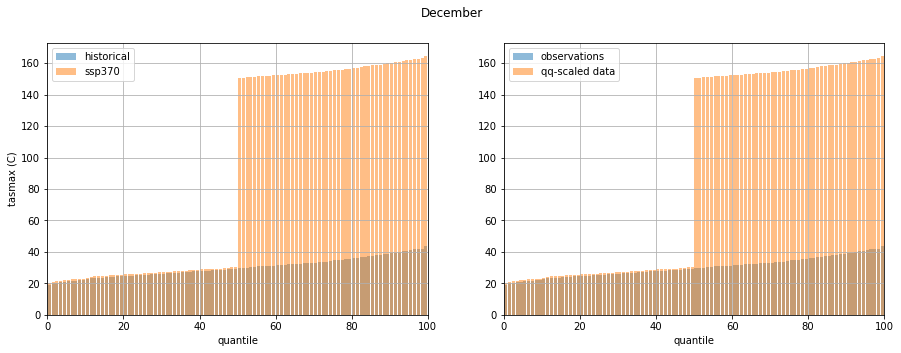

QQ-data
[  1.00000124   0.99999893   1.00000076   0.99999893   1.00000015
   1.00000031   1.00000092   0.99999924   1.           0.99999893
   0.99999832   1.00000107   1.           0.99999878   1.00000046
   1.00000153   1.00000092   1.00000076   0.99999847   1.00000122
   1.00000015   0.99999893   1.00000153   0.99999847   1.00000092
   1.00000015   0.99999924   1.00000076   0.99999908   1.00000015
   1.00000076   0.99999832   0.99999924   0.99999863   1.00000046
   1.00000031   1.00000046   1.           1.00000092   1.00000153
   1.00000092   0.99999847   1.           1.00000153   1.00000122
   0.99999832   0.99999802   1.00000153   1.00000031   0.99999786
 121.00000137 121.00000122 121.00000153 120.99999847 120.99999802
 120.99999908 121.00000072 120.99999847 121.00000092 120.99999771
 121.00000183 120.99999832 121.         120.99999908 121.00000397
 120.99999908 121.00000092 120.99999695 120.99999817 121.00000397
 121.00000153 121.00000275 121.         120.99999634 121.00000214
 1

In [15]:
for month in range(12):
    compare_quantiles(month)